En este script se realizan las predicciones de los modelos entrenados, sobre el conjunto de test.

Primero comenzamos importando las librerías necesarias

In [12]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pycocotools.coco import COCO
from tqdm import tqdm
from pathlib import Path

In [13]:
# Rutas proporcionadas
from operator import contains, index


ROOT_DIR = Path.cwd()
DATASET_DIR = ROOT_DIR / "dataset"
IMAGES_DIR = DATASET_DIR / "val2017"  
ANNOTATIONS_FILE = DATASET_DIR / "annotations" / "instances_val2017.json"

# Cargar anotaciones una sola vez
coco = COCO(ANNOTATIONS_FILE)
existing_img_ids = os.listdir(IMAGES_DIR)
img_ids = [img_id for img_id in coco.getImgIds() if f"{img_id:012}.jpg" in existing_img_ids]

print(len(img_ids))

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
100


In [14]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

In [15]:
def evaluate_model(model_name, img_ids, coco, images_dir):
    model = YOLO(model_name)
    all_tp = 0
    all_fp = 0
    all_fn = 0
    
    for img_id in tqdm(img_ids, desc=f"Evaluando {model_name}"):
        # 1. Obtener Ground Truth
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        gt_boxes = [ann['bbox'] for ann in anns] # [x,y,w,h]
        gt_boxes = [[b[0], b[1], b[0]+b[2], b[1]+b[3]] for b in gt_boxes] # a [x1,y1,x2,y2]
        
        # 2. Predicción
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(images_dir, img_info['file_name'])
        results = model(img_path, verbose=False, conf=0.25)[0]
        pred_boxes = results.boxes.xyxy.cpu().numpy()
        
        # 3. Emparejamiento (Matching)
        matched_gt = set()
        tp_count = 0
        for p_box in pred_boxes:
            found_match = False
            for i, g_box in enumerate(gt_boxes):
                if i not in matched_gt and calculate_iou(p_box, g_box) >= 0.5:
                    tp_count += 1
                    matched_gt.add(i)
                    found_match = True
                    break
            if not found_match:
                all_fp += 1
        
        all_tp += tp_count
        all_fn += (len(gt_boxes) - len(matched_gt))
        
    # Calcular métricas finales
    precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0
    recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [16]:
model_variants = ['n', 's', 'm', 'l', 'x']
benchmark_results = []

for var in model_variants:
    m_name = f"yolov8{var}.pt"
    p, r, f1 = evaluate_model(model_name=m_name, img_ids=img_ids, coco=coco, images_dir=IMAGES_DIR)
    
    benchmark_results.append({
        "Modelo": m_name,
        "Precision": round(p, 3),
        "Recall": round(r, 3),
        "F1-Score": round(f1, 3)
    })

# Crear DataFrame y mostrar
df_results = pd.DataFrame(benchmark_results)
#df_results.sort_values(by="F1-Score", ascending=False, inplace=True)
df_results

Evaluando yolov8x.pt: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


,Modelo,Precision,Recall,F1-Score
0,yolov8n.pt,0.738,0.573,0.645
1,yolov8s.pt,0.724,0.634,0.676
2,yolov8m.pt,0.706,0.682,0.694
3,yolov8l.pt,0.749,0.674,0.709
4,yolov8x.pt,0.740,0.700,0.719


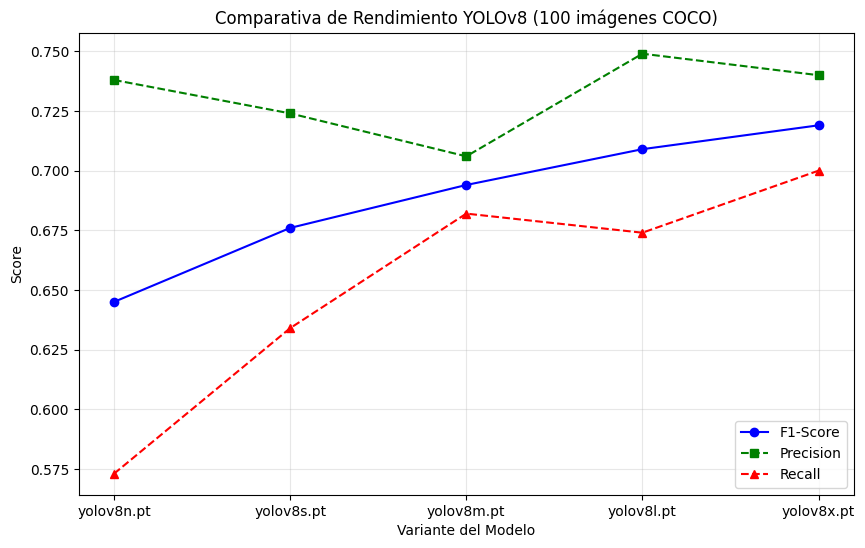

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df_results['Modelo'], df_results['F1-Score'], marker='o', linestyle='-', color='b', label='F1-Score')
plt.plot(df_results['Modelo'], df_results['Precision'], marker='s', linestyle='--', color='g', label='Precision')
plt.plot(df_results['Modelo'], df_results['Recall'], marker='^', linestyle='--', color='r', label='Recall')

plt.title('Comparativa de Rendimiento YOLOv8 (100 imágenes COCO)')
plt.xlabel('Variante del Modelo')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()